In [1]:
import os
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch
from torch import device
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision import io
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#!unzip -d ~/DS_bootcamp/kaggle/anime/data/ archive.zip

In [2]:
image_size = 64
batch_size = 128
latent_size= 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

preprocessing=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)])

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [3]:
def CustomImageDataset(path):
    data = []
    for i in sorted(os.listdir(path)):
        data.append(preprocessing(io.read_image(path+'/'+i)))
    dataset = torch.stack(data)
    return dataset

In [4]:
data_ldr = DataLoader(CustomImageDataset('data'), shuffle=True, batch_size=batch_size)

In [5]:
batch = next(iter(data_ldr))
print(batch.shape)
batch[0]

torch.Size([128, 3, 64, 64])


tensor([[[ 0.0431,  0.3255,  0.2392,  ..., -0.3882, -0.4196,  0.8353],
         [ 0.0510,  0.2392,  0.1137,  ..., -0.4039, -0.3961,  0.5059],
         [ 0.1608,  0.0431,  0.0824,  ..., -0.4118, -0.3961, -0.0510],
         ...,
         [-0.3412, -0.0196, -0.0039,  ..., -0.0275, -0.0510, -0.0824],
         [-0.3412, -0.3647, -0.0118,  ..., -0.0588, -0.0431, -0.3569],
         [-0.5137, -0.3961, -0.3412,  ..., -0.2314, -0.3647, -0.0039]],

        [[-0.2000,  0.0745,  0.0118,  ..., -0.5451, -0.5529,  0.8431],
         [-0.1765,  0.0039, -0.1451,  ..., -0.5529, -0.5373,  0.4745],
         [-0.0824, -0.1922, -0.1843,  ..., -0.5529, -0.5608, -0.1059],
         ...,
         [-0.5294, -0.2157, -0.2000,  ..., -0.1765, -0.2157, -0.2627],
         [-0.5294, -0.5529, -0.2000,  ..., -0.2157, -0.2000, -0.4902],
         [-0.6784, -0.5686, -0.5216,  ..., -0.3647, -0.4902, -0.2157]],

        [[-0.2706, -0.0039, -0.0667,  ..., -0.5529, -0.5529,  0.8353],
         [-0.2314, -0.0745, -0.2157,  ..., -0

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)            
        )

        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)            
        )

        self.upsample4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)    
        )

        self.upsample5 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.upsample4(x)
        x = self.upsample5(x)

        return x
generator = Generator()
summary(generator, (64, 1, 1), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [128, 512, 4, 4]         524,800
       BatchNorm2d-2           [128, 512, 4, 4]           1,024
              ReLU-3           [128, 512, 4, 4]               0
   ConvTranspose2d-4           [128, 256, 8, 8]       2,097,152
       BatchNorm2d-5           [128, 256, 8, 8]             512
              ReLU-6           [128, 256, 8, 8]               0
   ConvTranspose2d-7         [128, 128, 16, 16]         524,288
       BatchNorm2d-8         [128, 128, 16, 16]             256
              ReLU-9         [128, 128, 16, 16]               0
  ConvTranspose2d-10          [128, 64, 32, 32]         131,072
      BatchNorm2d-11          [128, 64, 32, 32]             128
             ReLU-12          [128, 64, 32, 32]               0
  ConvTranspose2d-13           [128, 3, 64, 64]           3,072
             Tanh-14           [128, 3,

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)            
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True) 
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

discriminator = Discriminator()
summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

In [8]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'image-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [9]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)

    real_targets = torch.ones(real_images.size(0), 1)

    real_loss = F.binary_cross_entropy(real_preds, real_targets) 

    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1)

    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1)

    fake_preds = discriminator(fake_images)

    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  

    fake_score = torch.mean(fake_preds).item()

    loss = torch.mean(real_loss + fake_loss)

    loss.backward()

    opt_d.step()

    return loss.item(), real_score, fake_score

In [10]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1,1)

    fake_images = generator(latent)
    
    preds = discriminator(fake_images)

    targets = torch.ones(batch_size, 1)
    
    loss = F.binary_cross_entropy(preds, targets) 
    
    loss.backward()

    opt_g.step()
    
    return loss.item(), latent

In [11]:
def fit(epochs=50, lr=0.0004, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
  
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images in tqdm(data_ldr):

            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g, latent = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print(f"[{epoch+1}/{epochs}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}, real_score: {real_score:.4f}, fake_score: {fake_score:.4f}")
    
        save_samples(epoch+start_idx, latent, show=True)
    
    return losses_g, losses_d, latent, fake_scores

In [12]:
#loss_g, loss_d, latent, fake_scores = fit(epochs=2)

In [14]:
#torch.save(generator, 'generator.pt')
#torch.save(discriminator, 'discriminator.pt')

In [13]:
generator = torch.load('generator.pt')
discriminator = torch.load('discriminator.pt')

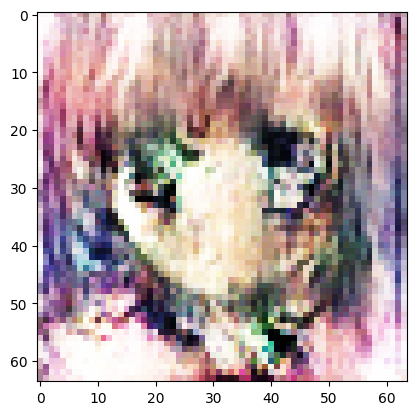

In [29]:
lt = torch.rand((64)).unsqueeze(1).unsqueeze(1).unsqueeze(0)
img = denorm(generator(lt))
plt.imshow(make_grid(img.cpu().detach(), nrow=8).permute(1, 2, 0));

In [301]:
def generate_pics(number):
    lt = torch.randn(number, 64, 1, 1)
    img = generator(lt)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'img.png'), nrow=8)
    img = io.read_image('generated/img.png')
    return img

In [174]:
import gradio as gr

In [300]:
def slider_input(slider):
    lt = torch.randn(slider, 64, 1, 1)
    img = generator(lt)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'img.png'), nrow=8)
    img = io.read_image('generated/img.png')
    return img
    
gr.Interface(fn=slider_input,
             inputs=[gr.Slider(1,100)],
             outputs=gr.Image()).launch()

Running on local URL:  http://127.0.0.1:7880

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x15b70d510>, 'http://127.0.0.1:7880/', None)

Traceback (most recent call last):
  File "/Users/aleksandrabudaeva/miniforge3/lib/python3.10/site-packages/gradio/routes.py", line 275, in run_predict
    output = await app.blocks.process_api(
  File "/Users/aleksandrabudaeva/miniforge3/lib/python3.10/site-packages/gradio/blocks.py", line 791, in process_api
    predictions = self.postprocess_data(fn_index, result["prediction"], state)
  File "/Users/aleksandrabudaeva/miniforge3/lib/python3.10/site-packages/gradio/blocks.py", line 759, in postprocess_data
    prediction_value = block.postprocess(prediction_value)
  File "/Users/aleksandrabudaeva/miniforge3/lib/python3.10/site-packages/gradio/components.py", line 1389, in postprocess
    raise ValueError("Cannot process this value as an Image")
ValueError: Cannot process this value as an Image
Traceback (most recent call last):
  File "/Users/aleksandrabudaeva/miniforge3/lib/python3.10/site-packages/gradio/routes.py", line 275, in run_predict
    output = await app.blocks.process_api(